In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from classes import Bandpasses, LightCurve, SNSurvey

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the LSST filters

In [3]:
bandpasses = Bandpasses()

Simulate a survey of SN1a

In [4]:
%%time
model = sncosmo.Model(source='salt2-extended')
params = {'z': 0, 't0': 0, 'x0': 1e-5, 'x1': 0.1, 'c': -0.1}
model.update(params)

survey = SNSurvey(model=model, zmax=0.75, area=1, cadence=1)
survey.simulate(bandpasses, norm=10, Ncpus=8)

print(survey)

SN Survey Simulation: 

    N obs = 356    
     zmin = 0      
     zmax = 0.75   
     area = 1      
 duration = 1000.0 
  cadence = 1      
flux errf = 0.05   

Model: 
source:
  class      : SALT2Source
  name       : 'salt2-extended'
  version    : 2.0
  phases     : [-20, .., 50] days
  wavelengths: [1700, .., 24990] Angstroms
parameters:
  z  = 0.0
  t0 = 0.0
  x0 = 1e-05
  x1 = 0.1
  c  = -0.1
CPU times: user 1.43 s, sys: 542 ms, total: 1.97 s
Wall time: 7.79 s


Print the first observation as an example:

In [5]:
print(survey.obs[0])

SkyObject Observation: 

     source = SN1a   
         t0 = 60001.3183 
     spec-z = 0.6845 
    photo-z = None   
photo-z err = None   
      N obs = 118    

   mjd     filter    flux   flux_err
---------- ------ --------- --------
59968.3796  lsstz  0.003806 0.000205
59969.2355  lssty  0.006112 0.000288
 59970.108  lsstu  0.015833  0.00079
59971.3552  lsstg  0.024339 0.001183
 59972.216  lsstr  -0.00348  0.00017
59973.3008  lssti  0.107058 0.005036
       ...    ...       ...      ...
 60079.986  lsstr  0.271914 0.012885
60081.3965  lssti  0.361752 0.017787
60082.3733  lsstz  0.431719 0.020857
60083.2153  lssty  0.515672 0.024485
60084.0337  lsstu -0.098181 0.004785
60085.2029  lsstg  0.081019 0.003928
Length = 118 rows


Plot the flux of the SALT2 model the survey is simulated from

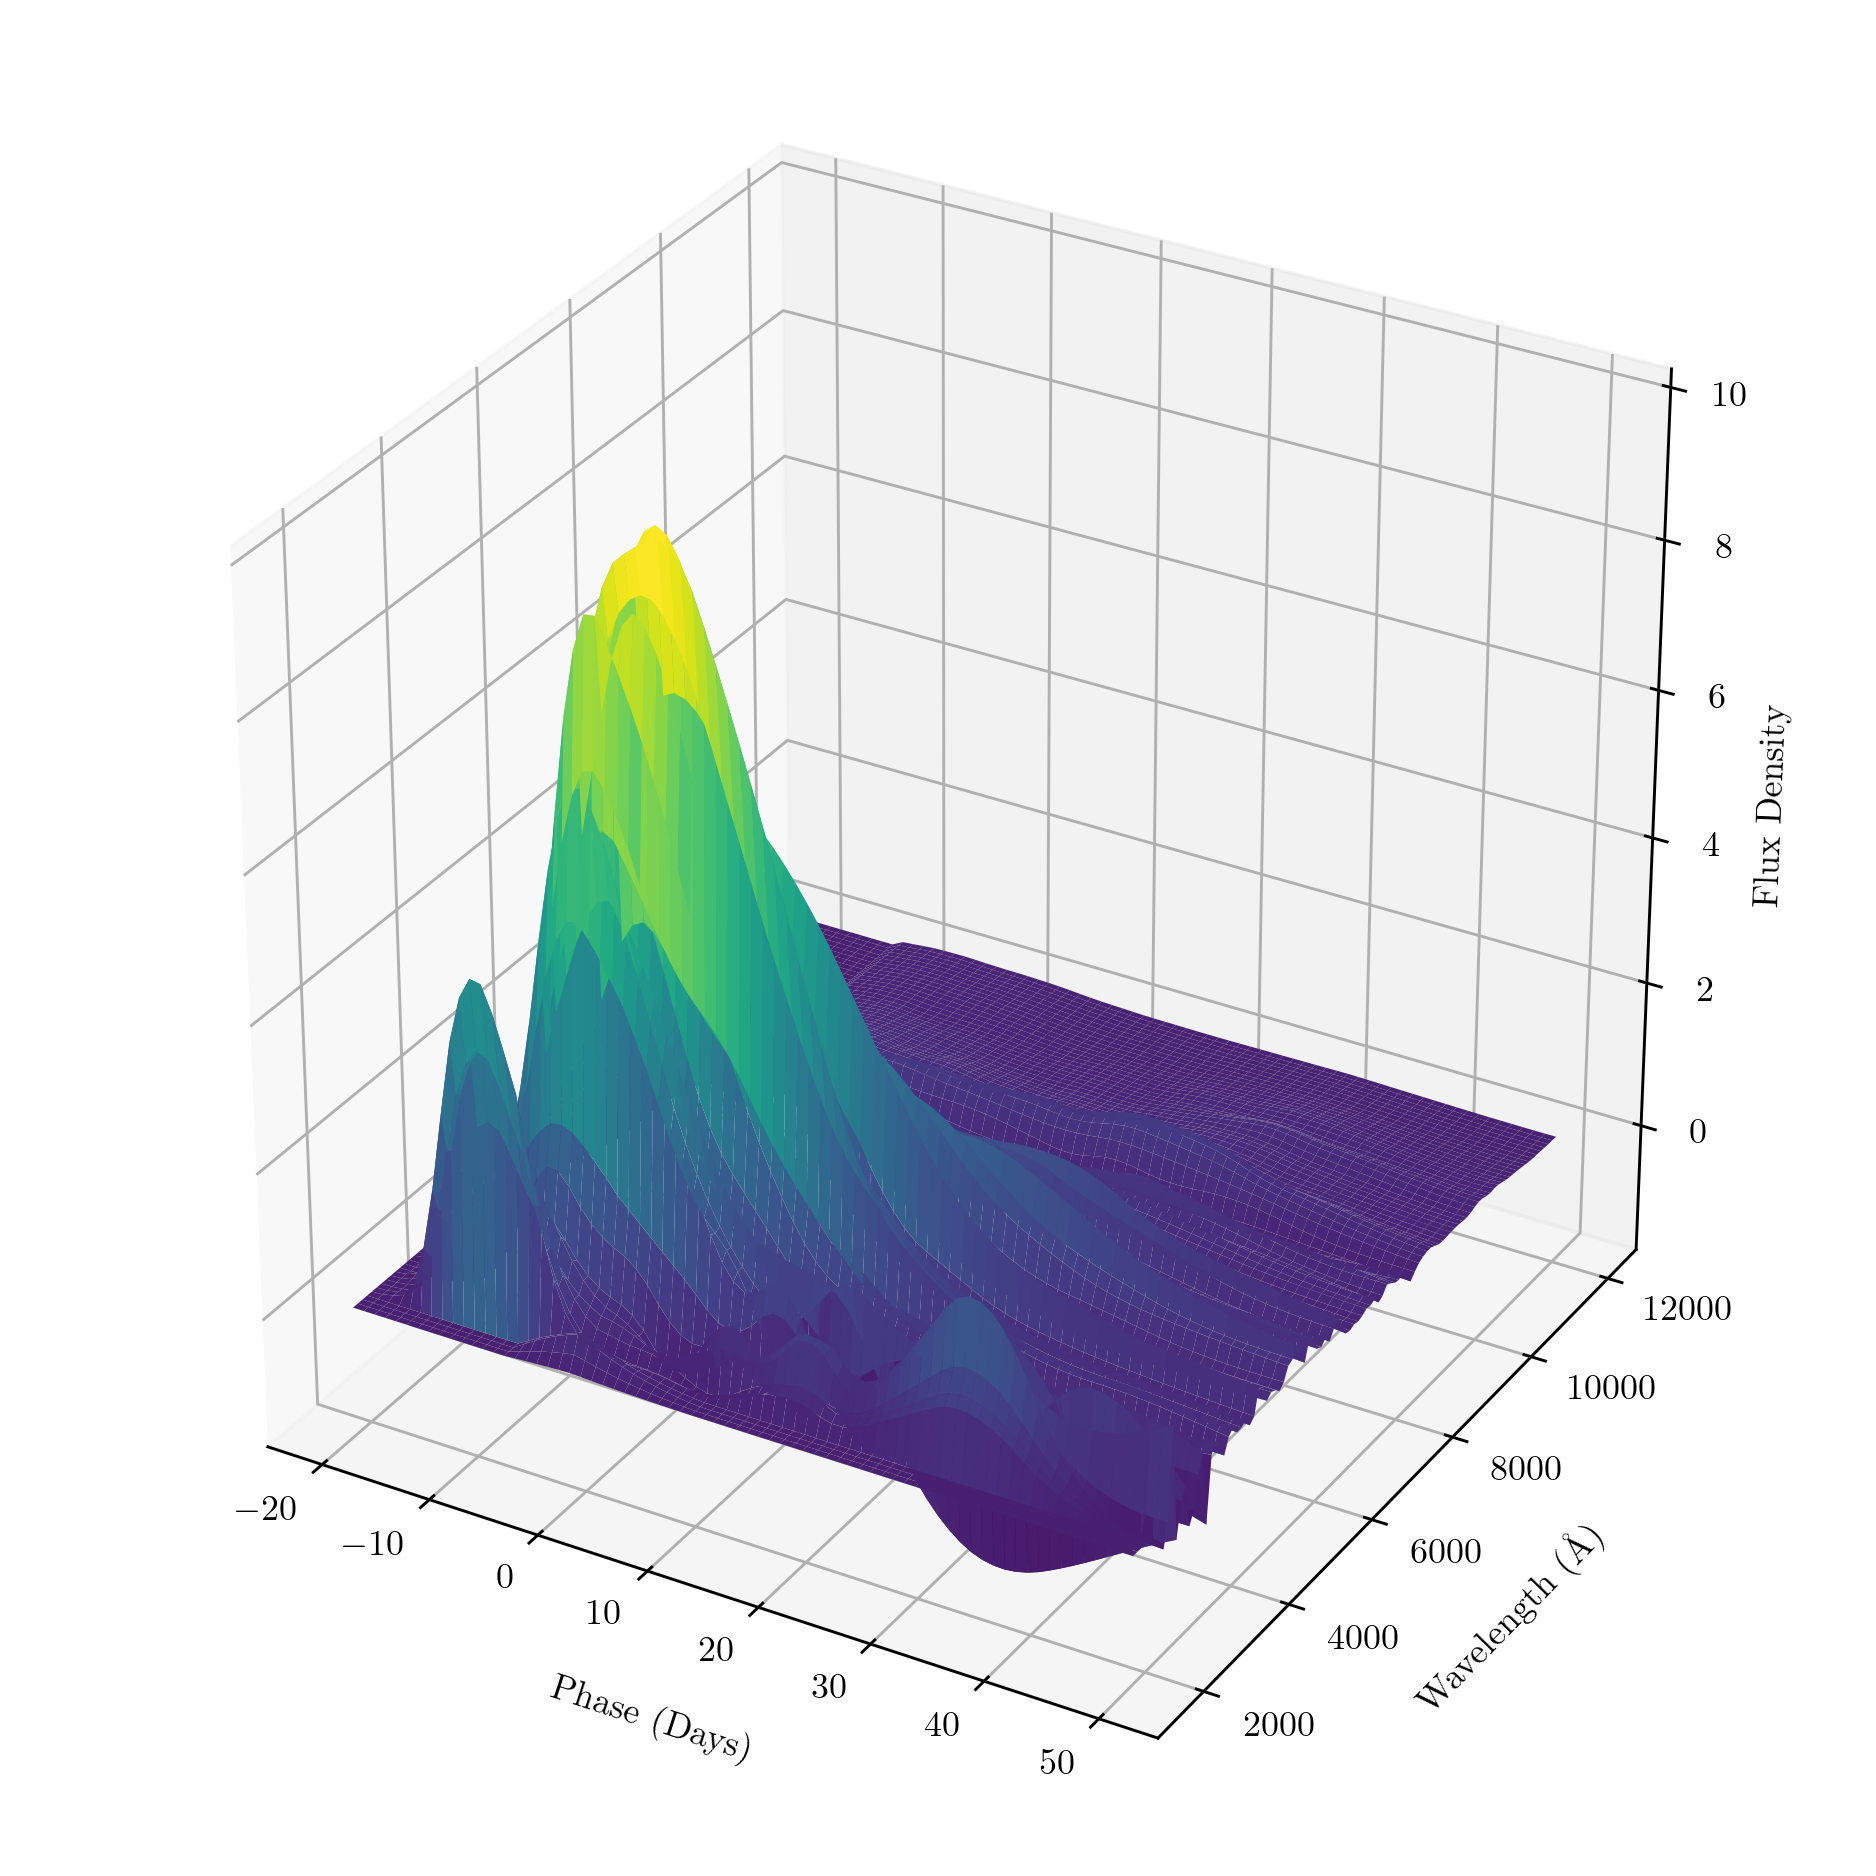

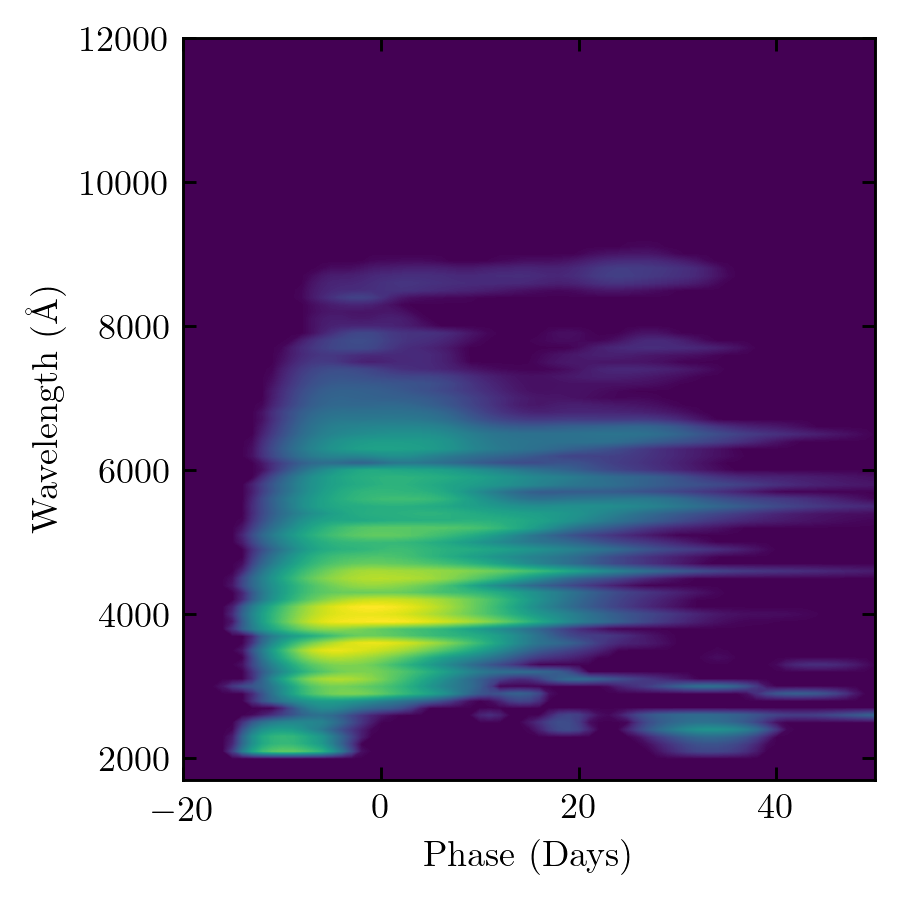

In [6]:
time = np.arange(model.mintime(), model.maxtime() + 1)
wavelen = np.arange(model.minwave(), 12100, 100)
lc = LightCurve(time, wavelen)
lc.from_model(model)
fig = lc.surface_plot()
fig = lc.contour_plot()

Now we start with a totally null light curve

In [7]:
time = np.arange(model.mintime(), model.maxtime() + 1)
wavelen = np.arange(model.minwave(), 12100, 100)
lcn = LightCurve(time, wavelen)
lcn.null()

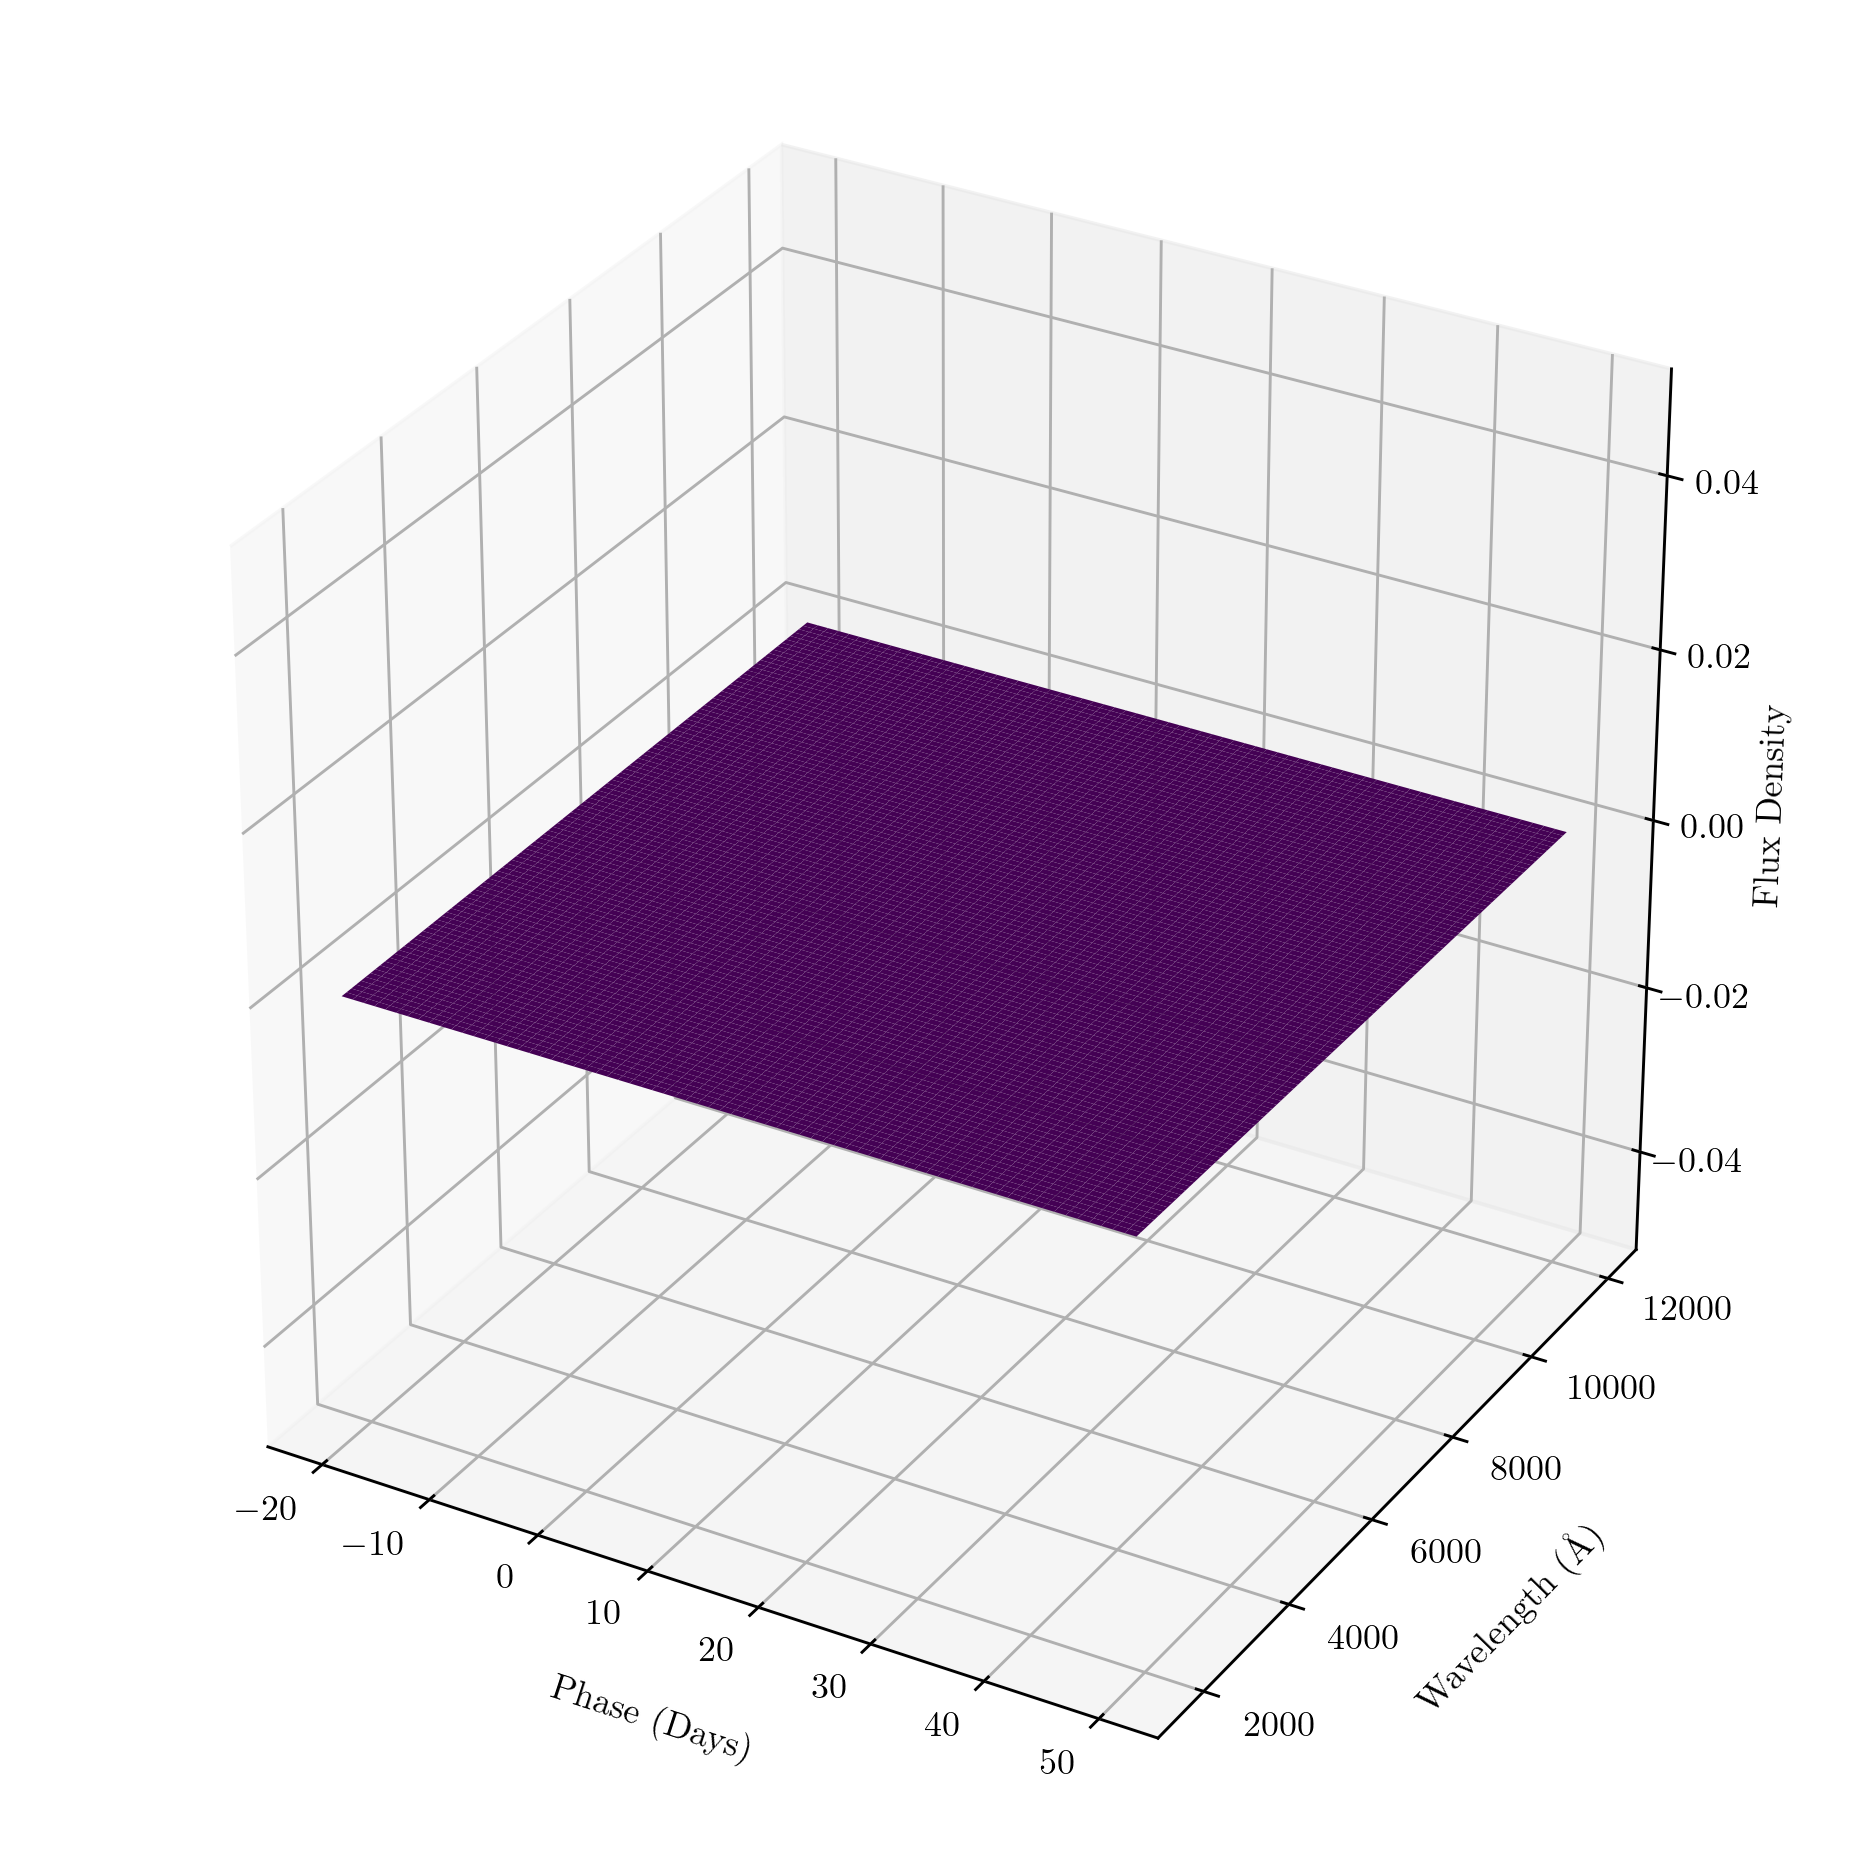

In [8]:
fig = lcn.surface_plot()

Let's make the time-slice training sets:

In [9]:
%time training_sets = lcn.training_sets(survey.obs)

CPU times: user 9.74 s, sys: 94.2 ms, total: 9.83 s
Wall time: 9.82 s


Now train the light curve on the photometry in the simulated survey

In [10]:
%time lcn.train(training_sets, bandpasses, Ncpus=1, verbose=True)

-20.0
 Consider raising the range of alphas tested.
-19.0
 Consider raising the range of alphas tested.
-18.0
 Consider raising the range of alphas tested.
 Consider raising the range of N_EDBs tested.
 Consider lowering the range of Max widths tested.
-17.0
 Consider lowering the range of Max widths tested.
-16.0
 Consider raising the range of alphas tested.
 Consider lowering the range of Max widths tested.
-15.0
 Consider raising the range of alphas tested.
-14.0
 Consider raising the range of alphas tested.
 Consider lowering the range of N_EDBs tested.
 Consider lowering the range of Max widths tested.
-13.0
 Consider raising the range of alphas tested.
 Consider lowering the range of Max widths tested.
-12.0
 Consider raising the range of alphas tested.
 Consider lowering the range of Max widths tested.
-11.0
 Consider raising the range of alphas tested.
 Consider lowering the range of Max widths tested.
-10.0
 Consider raising the range of alphas tested.
 Consider lowering the r

Now plot the results!

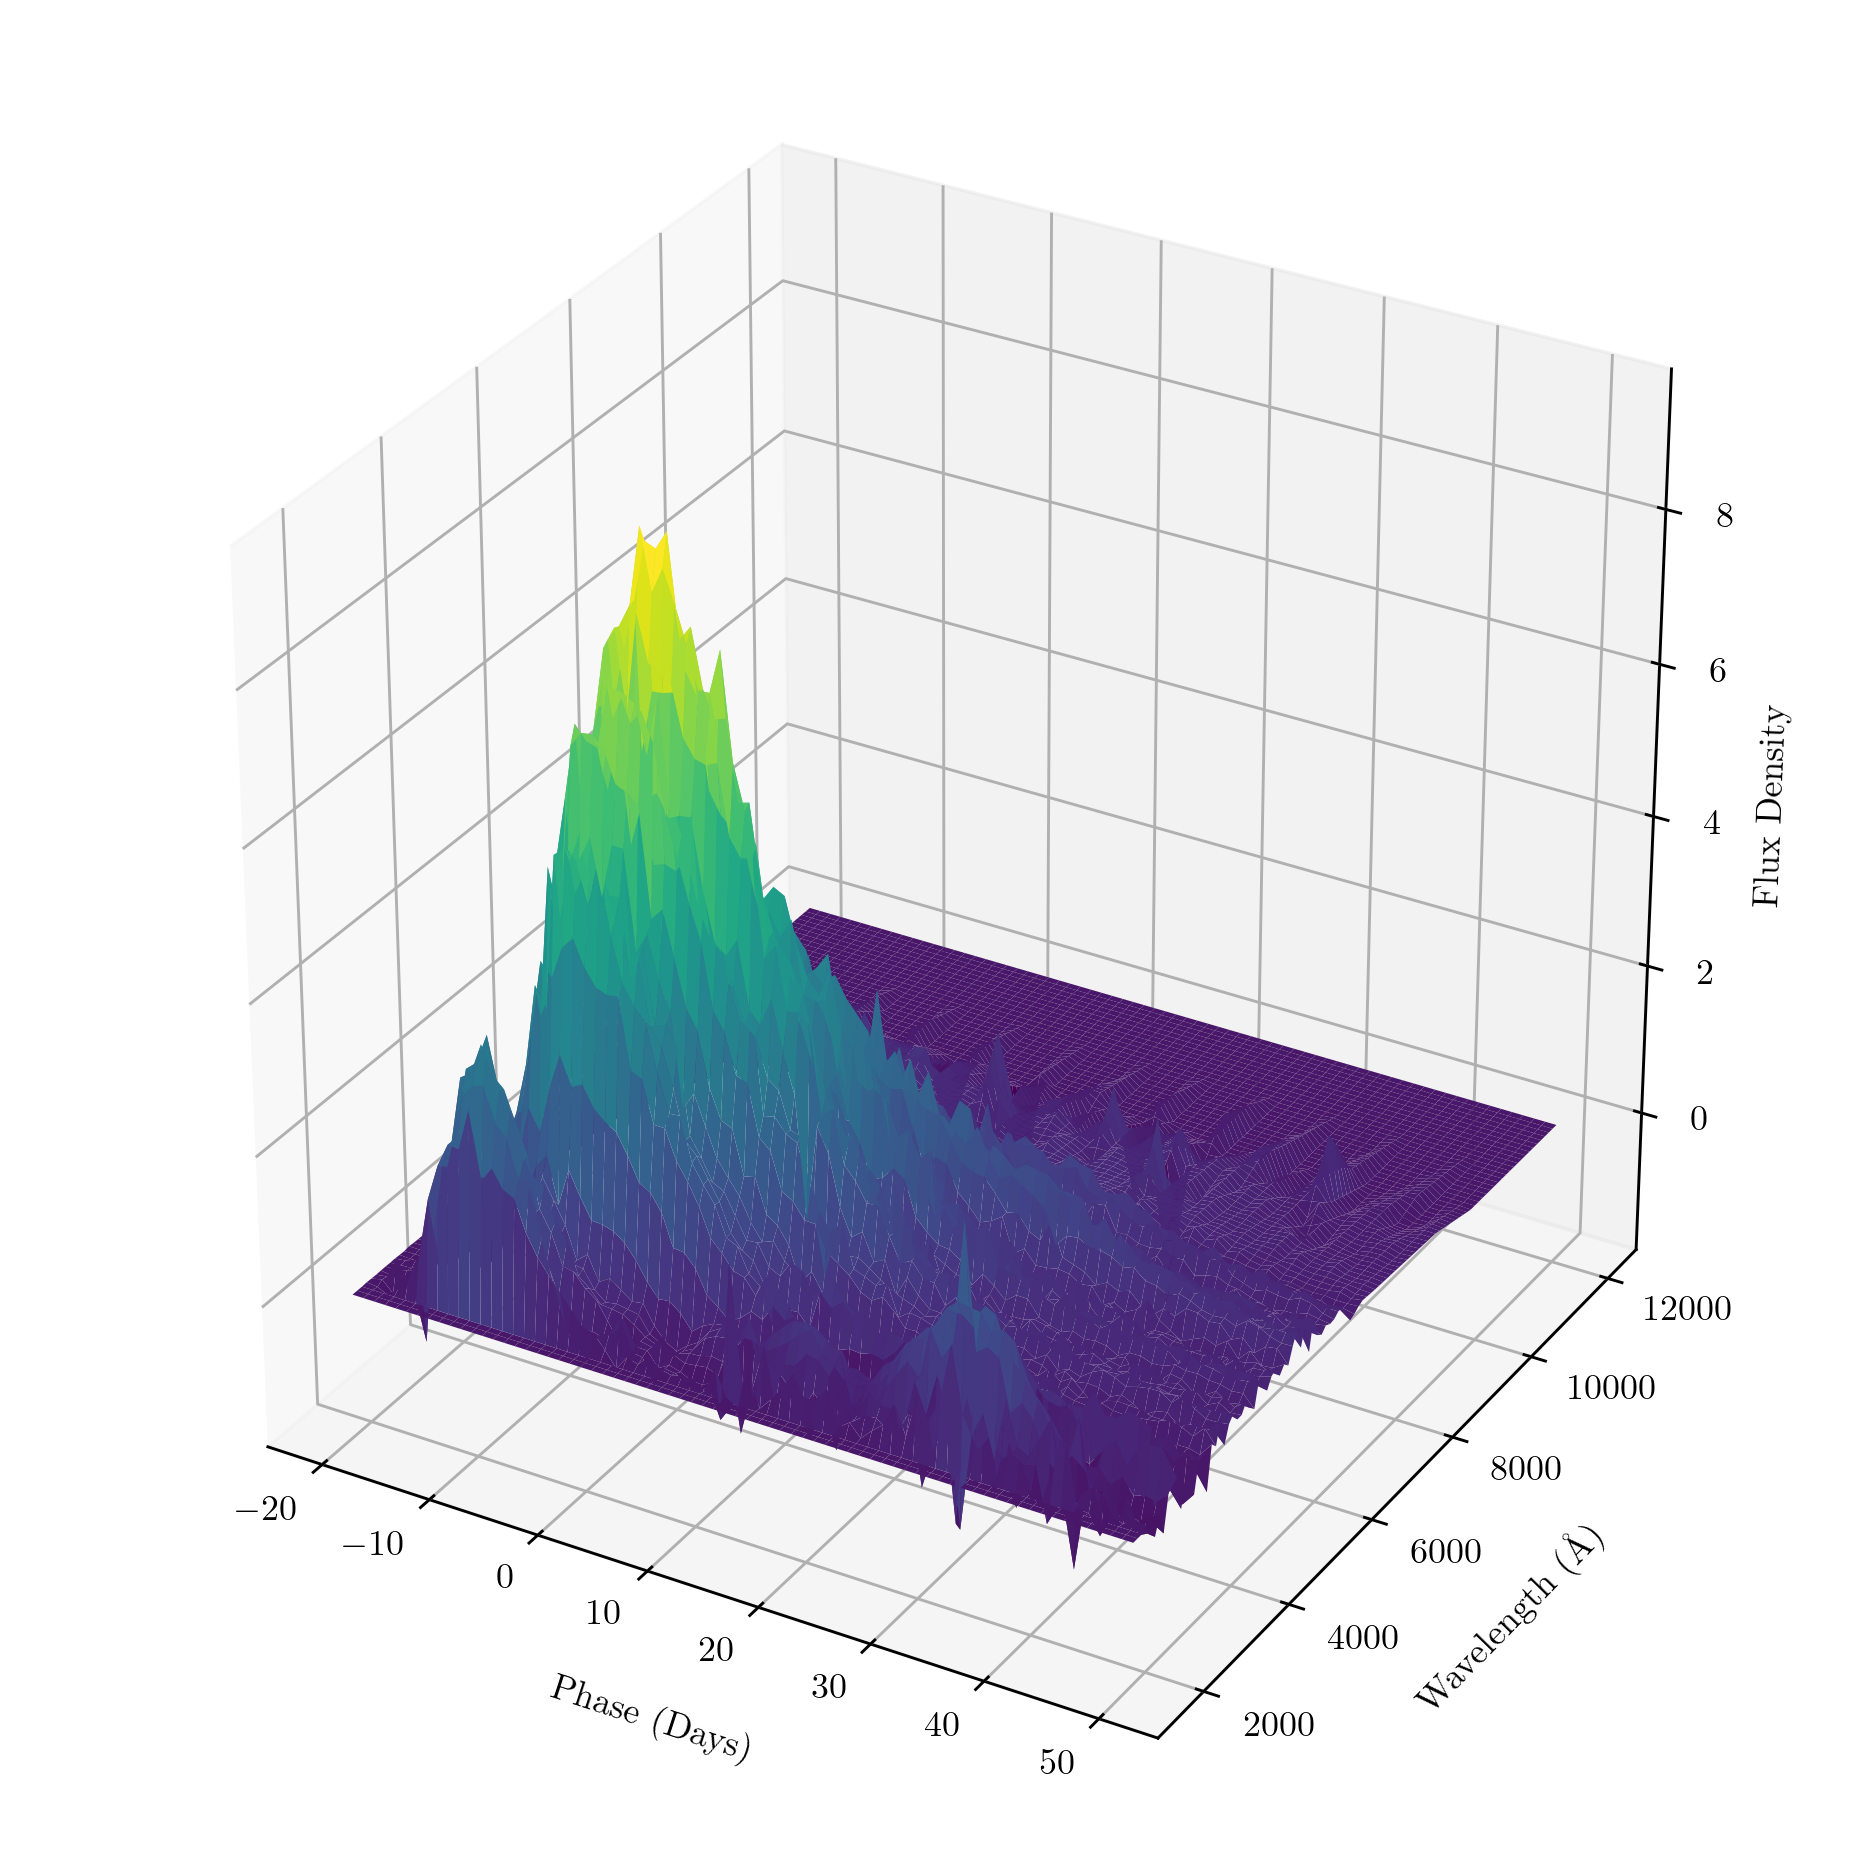

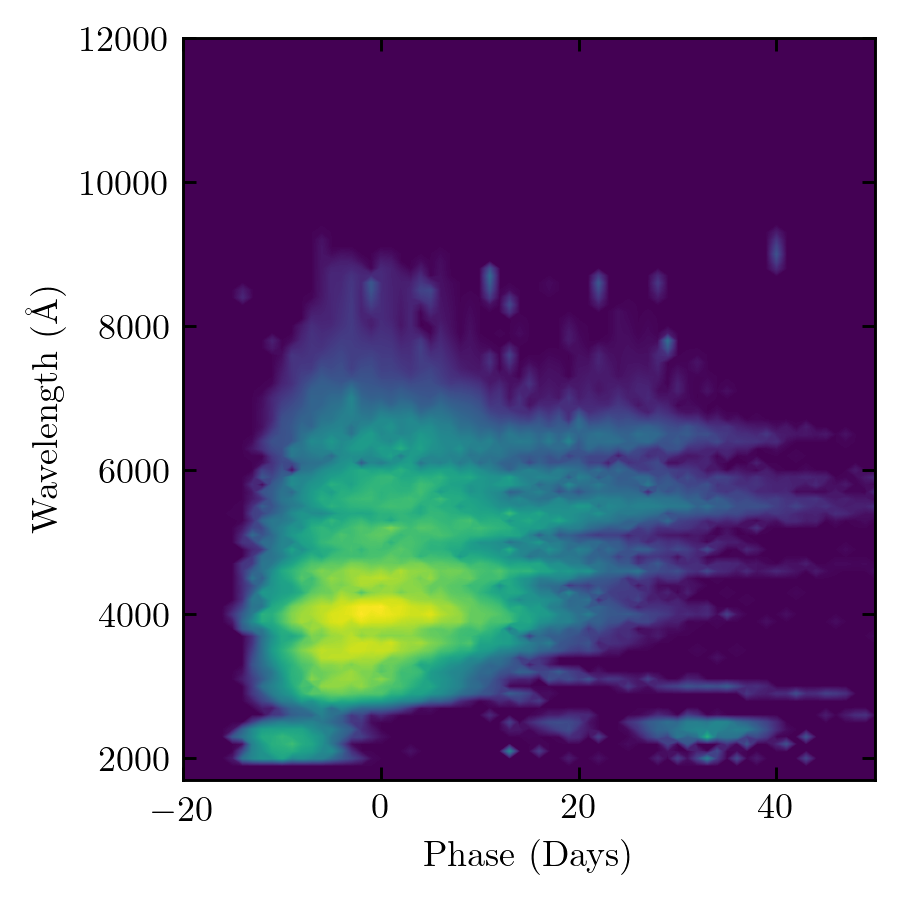

In [11]:
lcn.surface_plot()
lcn.contour_plot()
plt.show()

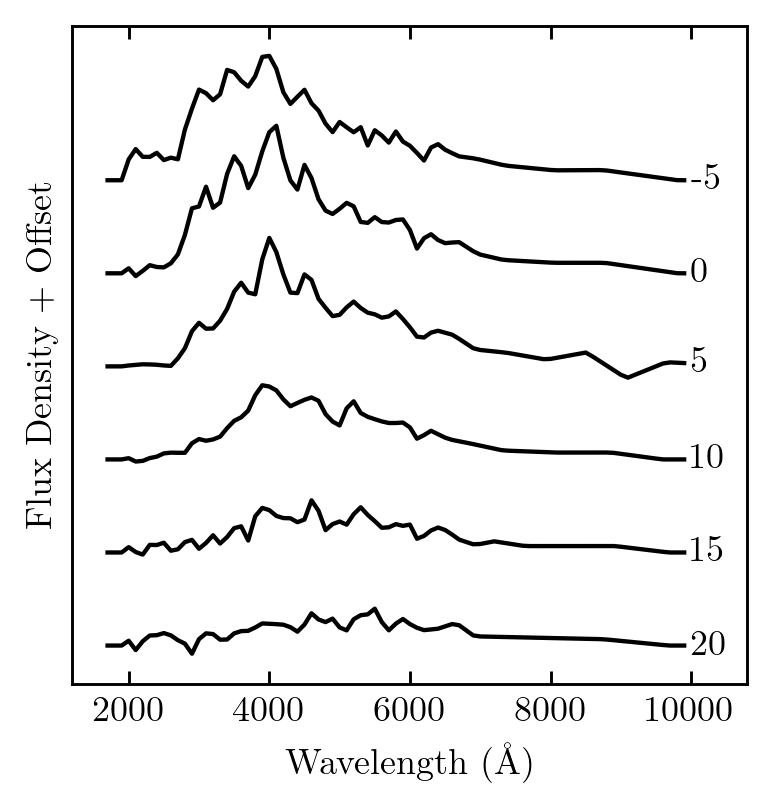

In [12]:
trange = [-5,0,5,10,15,20]
lcn.stacked_plot(trange, offset_scale=6)
plt.show()

Now I will make comparison plots. I plot the surfaces and contours side by side, and make a plot of the residuals.

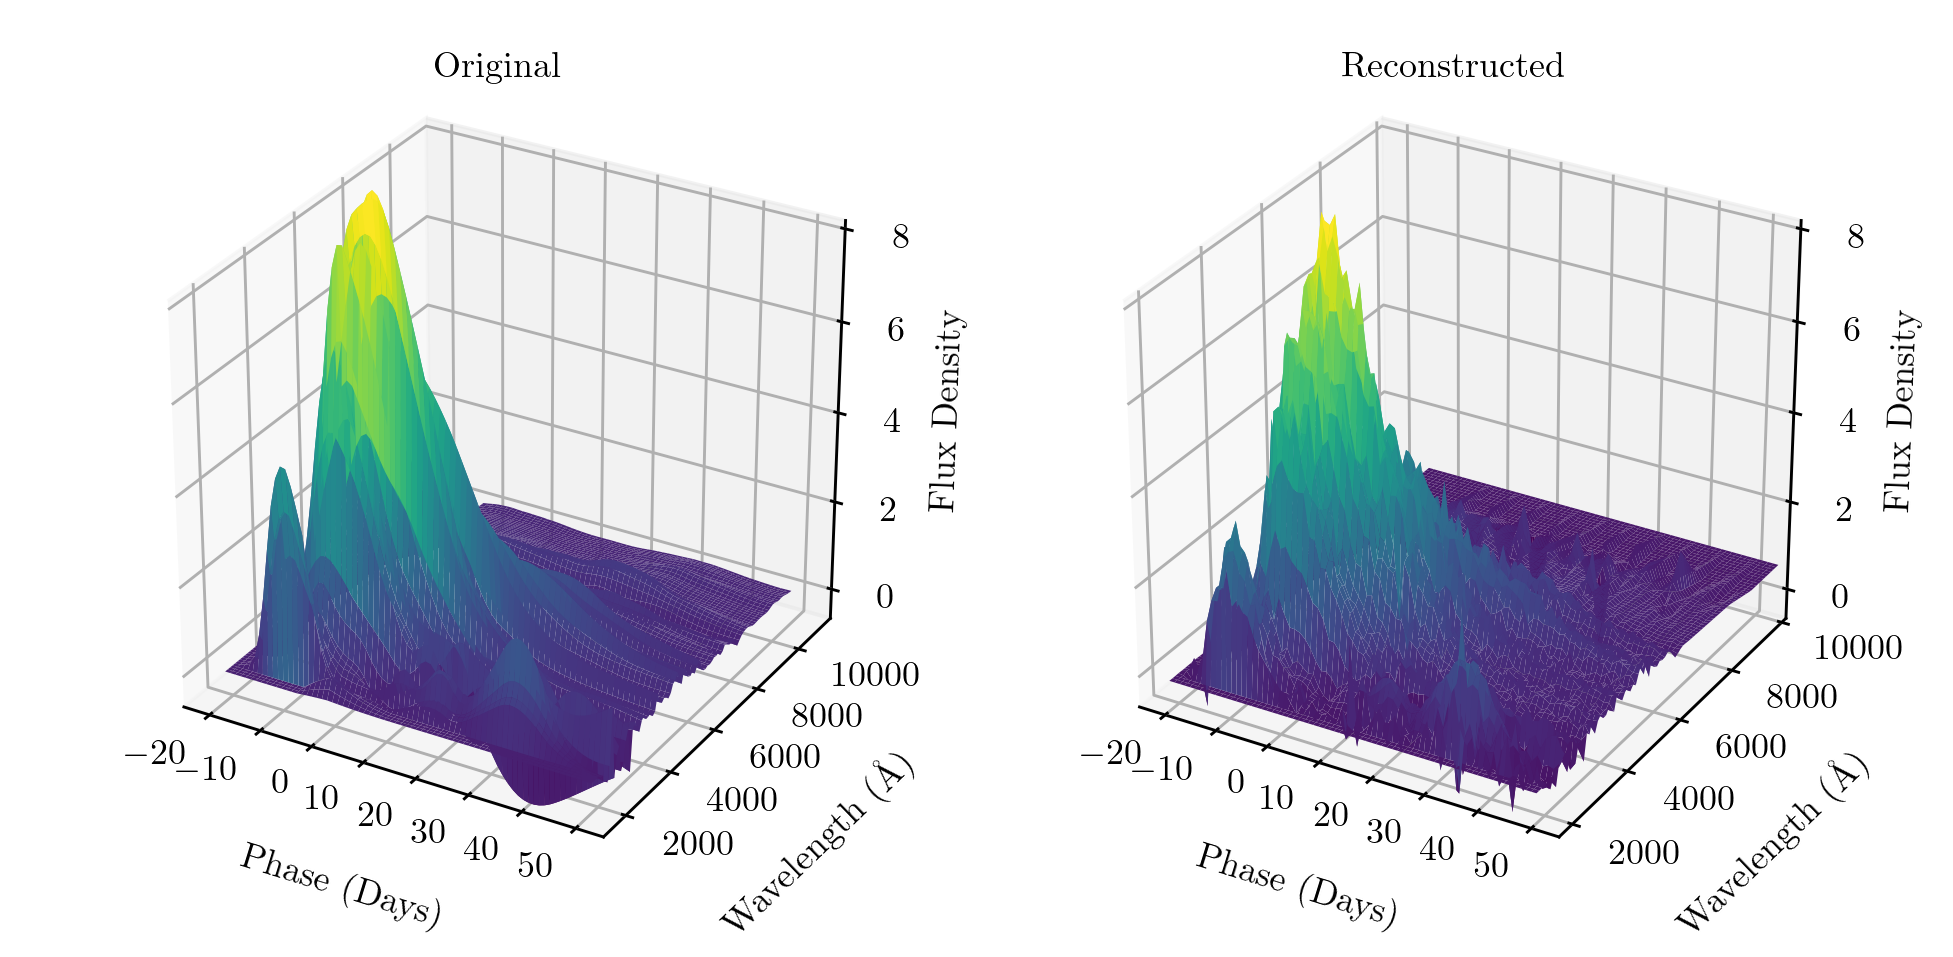

In [16]:
fig = plt.figure(figsize=(twocol,onecol))

ymax = 11000
idx = np.abs(lc.wavelen - ymax).argmin()
x, y = np.meshgrid(lc.time, lc.wavelen[:idx])

ax = fig.add_subplot(1,2,1, projection='3d')
ax.dist = 11

ax.plot_surface(x, y, lc.flux(lc.time,lc.wavelen[:idx]), cmap='viridis', rcount=200, ccount=200)
ax.set_zlim(-0.5, 8)
plt.setp( ax.xaxis.get_majorticklabels(), va="bottom", ha='right' )
plt.setp( ax.yaxis.get_majorticklabels(), va="bottom", ha='left' )
ax.set_xlabel("Phase (Days)", ha='left')
ax.set_ylabel("Wavelength ($\mathrm{\AA}$)", labelpad=10)
ax.set_zlabel("Flux Density", labelpad=2)
ax.set_title("Original")

ax = fig.add_subplot(1,2,2, projection='3d')
ax.dist = 11
ax.plot_surface(x, y, lcn.flux(lcn.time,lcn.wavelen[:idx]), cmap='viridis', rcount=200, ccount=200)
ax.set_ylim(1700,10000)
ax.set_zlim(-0.5, 8)
plt.setp( ax.xaxis.get_majorticklabels(), va="bottom", ha='right' )
plt.setp( ax.yaxis.get_majorticklabels(), va="bottom", ha='left' )
ax.set_xlabel("Phase (Days)")
ax.set_ylabel("Wavelength ($\mathrm{\AA}$)", labelpad=10)
ax.set_zlabel("Flux Density", labelpad=2)
ax.set_title("Reconstructed")

plt.subplots_adjust(wspace=0.01,top=1.07,bottom=0.03,left=-0.04,right=0.99)
fig.savefig('plots/surface_comparison.png')

In [15]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(twocol,onecol),constrained_layout=True)

x,y = np.meshgrid(lc.time, lc.wavelen)

zcut = np.max(lc.flambda)/20
z = np.log10( np.clip(lc.flambda, zcut, None) )
ax1.contourf(x, y, z, levels=200)
ax1.set_xlabel("Phase (Days)")
ax1.set_ylabel("Wavelength ($\mathrm{\AA}$)")
ax1.set_ylim(1700, 11000)
ax1.text(0.5, 0.95, 'Original', transform=ax1.transAxes, ha='center', va='center', c='w')

zcut = np.max(lcn.flambda)/20
z = np.log10( np.clip(lcn.flambda, zcut, None) )
ax2.contourf(x, y, z, levels=200)
ax2.set_xlabel("Phase (Days)")
ax2.set_ylabel("Wavelength ($\mathrm{\AA}$)")
ax2.set_ylim(1700,11000)
ax2.text(0.5, 0.95, 'Reconstructed', transform=ax2.transAxes, ha='center', va='center', c='w')

fig.savefig('plots/contour_comparison.png')

In [18]:
fig,ax = plt.subplots()
P = 0
sed = lc.sed_slice(P)
ax.plot(sed.wavelen,sed.flambda,label="Original")
sed = lcn.sed_slice(P)
ax.plot(sed.wavelen,sed.flambda,label="Reconstructed")
ax.legend()
ax.set_xlabel("Wavelength ($\mathrm{\AA}$)")
ax.set_ylabel("Flux Density")

fig.savefig(f'plots/phase{P}_comparison.png')

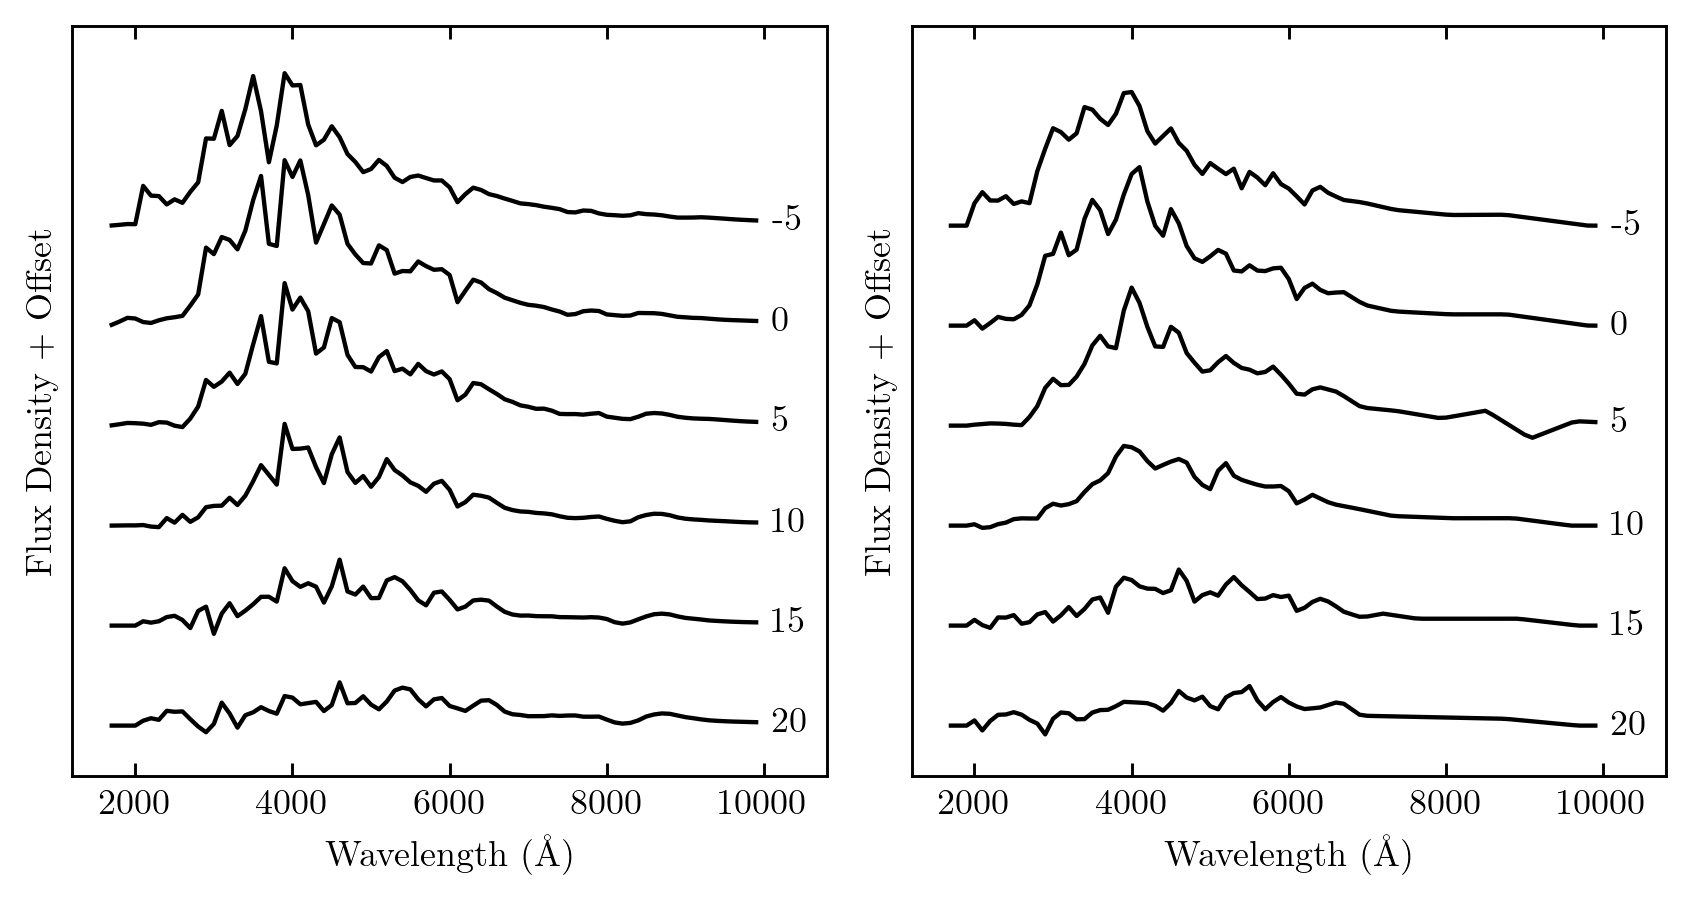

In [21]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(0.9*twocol,onecol),constrained_layout=True)

trange = [-5,0,5,10,15,20]
offset_scale = 6

for i,t in enumerate(trange):
    sed = lc.sed_slice(t)
    idx = np.abs(sed.wavelen - 10000).argmin()
    ax1.plot(sed.wavelen[:idx], sed.flambda[:idx] + len(trange) - i*offset_scale, c='k')
    ax1.text(sed.wavelen[idx] + 100, sed.flambda[idx] + len(trange) - i*offset_scale, t, ha='left', va='center')

ax1.set_xlabel("Wavelength ($\mathrm{\AA}$)")
ax1.set_ylabel("Flux Density + Offset")
ax1.set_xlim(1200,10800)
ax1.set_ylim(-27, 18)
ax1.set_yticks([])

for i,t in enumerate(trange):
    sed = lcn.sed_slice(t)
    idx = np.abs(sed.wavelen - 10000).argmin()
    ax2.plot(sed.wavelen[:idx], sed.flambda[:idx] + len(trange) - i*offset_scale, c='k')
    ax2.text(sed.wavelen[idx] + 100, sed.flambda[idx] + len(trange) - i*offset_scale, t, ha='left', va='center')

ax2.set_xlabel("Wavelength ($\mathrm{\AA}$)")
ax2.set_ylabel("Flux Density + Offset")
ax2.set_xlim(1200,10800)
ax2.set_ylim(-27, 18)
ax2.set_yticks([])

fig.savefig('plots/stacked_comparison.png')

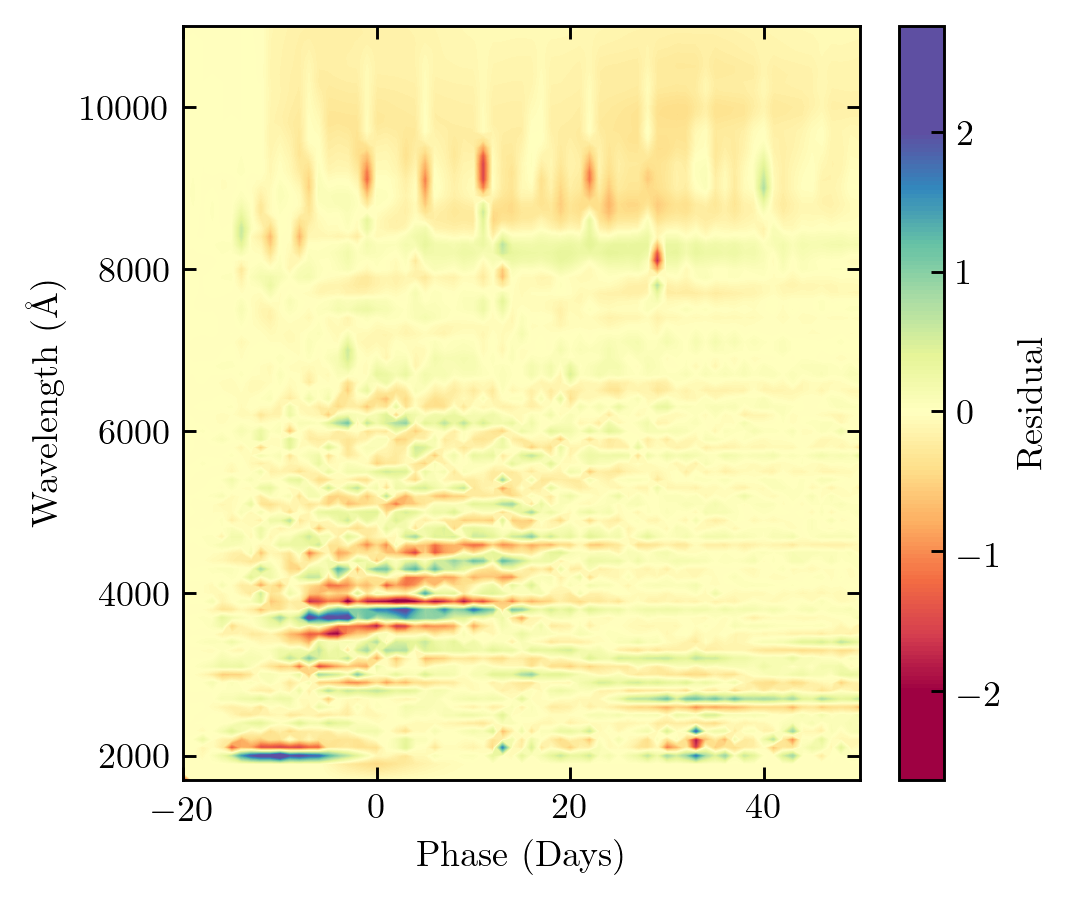

In [23]:
fig,ax = plt.subplots(figsize=(1.2*onecol,onecol), constrained_layout=True)

z = (lcn.flambda - lc.flambda)
zmax = 2
z[0,0], z[-1,-1] = -zmax, zmax
cont = ax.contourf(lc.time, lc.wavelen, z, cmap='Spectral', vmin=-zmax, vmax=zmax, levels=200)
fig.colorbar(cont, ticks=[-2,-1,0,1,2], label='Residual')
ax.set_xlabel("Phase (Days)")
ax.set_ylabel("Wavelength ($\mathrm{\AA}$)")
ax.set_ylim(1700,11000)

fig.savefig('plots/residuals.png')
plt.show()